In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/PhalangesOutlinesCorrect/"

In [5]:
dataset_name = "phalanges"

In [6]:
X = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TRAIN.txt", header=None, delim_whitespace=True)
y_all = np.array(X[0]).astype("int")
#y_all[y_all == -1] = 0

X_all = X.iloc[:,1:].values
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [7]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (1800, 80, 1)
y SHAPE:  (1800,)

CLASSES BALANCE
0 :  0.35
1 :  0.65


In [8]:
X_test = pd.read_csv(dataset_path + "PhalangesOutlinesCorrect_TEST.txt", header=None, delim_whitespace=True)
y_test = np.array(X_test[0]).astype("int")
#y_all[y_all == -1] = 0

X_test = X_test.iloc[:,1:].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
print("X SHAPE: ", X_test.shape)
print("y SHAPE: ", y_test.shape)

X SHAPE:  (858, 80, 1)
y SHAPE:  (858,)


## DATASET SPLIT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (1008, 80, 1)
BLACKBOX VALIDATION SET:  (252, 80, 1)
BLACKBOX TEST SET:  (858, 80, 1)
EXPLANATION TRAINING SET:  (345, 80, 1)
EXPLANATION VALIDATION SET:  (87, 80, 1)
EXPLANATION TEST SET:  (108, 80, 1)


In [12]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  80
N. LABELS:  2


# BLACKBOX MODEL

In [13]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import UpSampling1D
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Dropout
from keras.layers import Reshape
from keras.utils import to_categorical
import time

Using TensorFlow backend.


In [14]:
from blackboxes import *

In [15]:
import blackboxes

In [16]:
import importlib
importlib.reload(blackboxes)

<module 'blackboxes' from '/Users/francesco/github/TS_AgnosticLocalExplainer/blackboxes.py'>

## resnet

In [17]:
blackbox = build_resnet(n_timesteps, n_outputs)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_resnet_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [18]:
blackbox.fit(X_train, y_train, epochs=20, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1008 samples, validate on 252 samples
Epoch 1/20
1008/1008 [==============================] - 12s 12ms/step - loss: 0.6427 - acc: 0.6647 - val_loss: 1.7745 - val_acc: 0.6508

Epoch 00001: val_acc improved from -inf to 0.65079, saving model to ./blackbox_checkpoints/phalanges_blackbox_resnet_20191101_170717_best_weights_+0.65_.hdf5
Epoch 2/20
1008/1008 [==============================] - 8s 8ms/step - loss: 0.5876 - acc: 0.7133 - val_loss: 0.8403 - val_acc: 0.6548

Epoch 00002: val_acc improved from 0.65079 to 0.65476, saving model to ./blackbox_checkpoints/phalanges_blackbox_resnet_20191101_170717_best_weights_+0.65_.hdf5
Epoch 3/20
1008/1008 [==============================] - 8s 8ms/step - loss: 0.5654 - acc: 0.7262 - val_loss: 0.8828 - val_acc: 0.6706

Epoch 00003: val_acc improved from 0.65476 to 0.67063, saving model to ./blackbox_checkpoints/phalanges_blackbox_resnet_20191101_170717_best_weights_+0.67_.hdf5
Epoch 4/20
1008/10

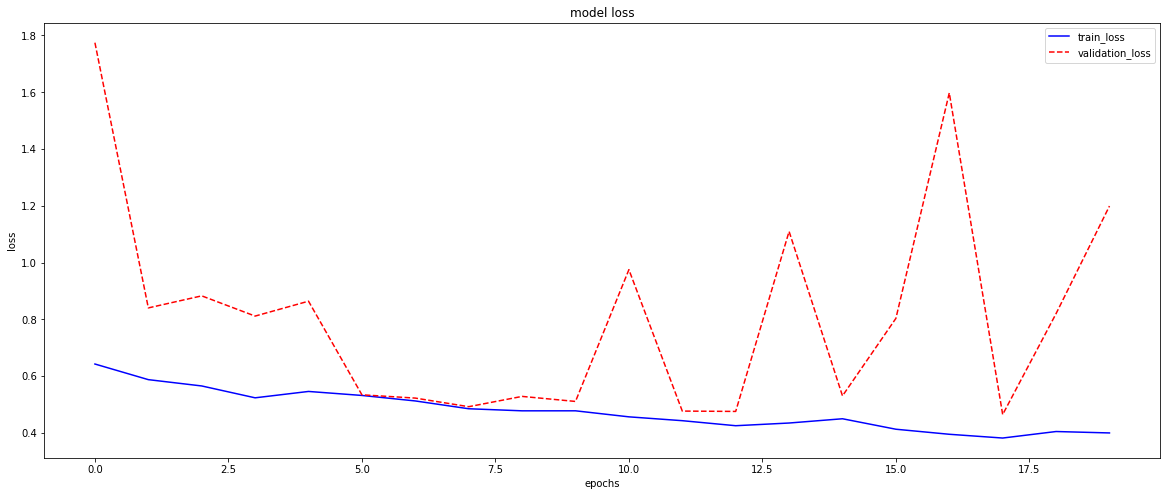

In [19]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["loss"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

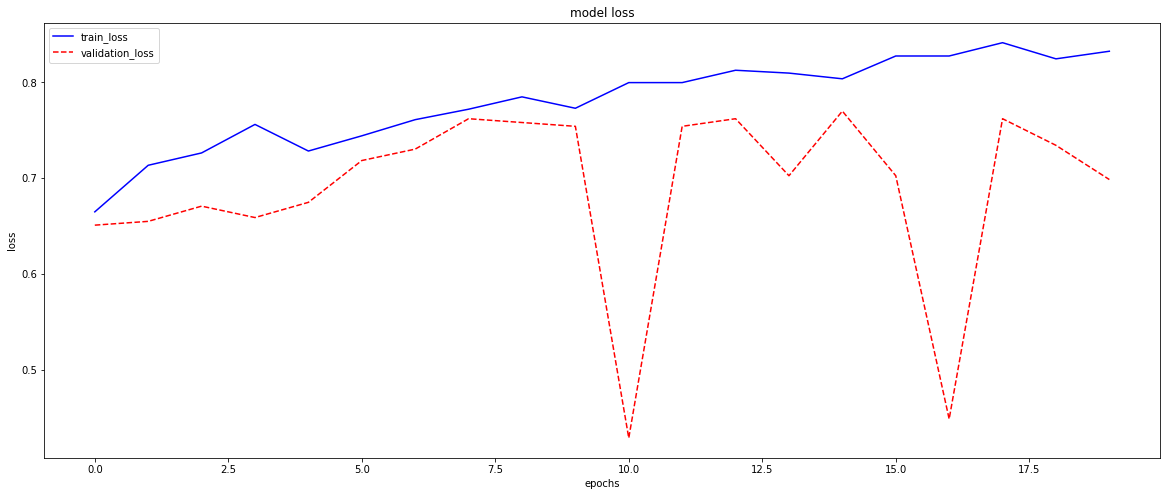

In [20]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["acc"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_acc"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [18]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_resnet_20191101_164247_best_weights_+0.86_.hdf5")

In [19]:
blackbox.evaluate(X_test, y_test)

858/858 [==============================] - 2s 2ms/step


[0.8015891332309563, 0.8286713279766359]

In [20]:
resnet = blackbox

## simple CNN

In [21]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
file_path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_simpleCNN_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_acc:.2f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_acc', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)

callbacks = [reduce_lr, model_checkpoint]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 73, 16)            144       
_________________________________________________________________
batch_normalization_13 (Batc (None, 73, 16)            64        
_________________________________________________________________
activation_10 (Activation)   (None, 73, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 16)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 69, 32)            2592      
_________________________________________________________________
batch_normalization_14 (Batc (None, 69, 32)            128       
_____

In [26]:
blackbox.fit(X_train, y_train, epochs=50, batch_size=mini_batch_size, callbacks = callbacks,
             validation_data=(X_val, y_val))

Train on 1008 samples, validate on 252 samples
Epoch 1/50
1008/1008 [==============================] - 3s 2ms/step - loss: 0.6476 - acc: 0.6518 - val_loss: 0.6502 - val_acc: 0.6508

Epoch 00001: val_acc improved from -inf to 0.65079, saving model to ./blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_171238_best_weights_+0.65_.hdf5
Epoch 2/50
1008/1008 [==============================] - 1s 803us/step - loss: 0.6350 - acc: 0.6508 - val_loss: 0.6349 - val_acc: 0.6508

Epoch 00002: val_acc did not improve from 0.65079
Epoch 3/50
1008/1008 [==============================] - 1s 819us/step - loss: 0.6345 - acc: 0.6548 - val_loss: 0.6592 - val_acc: 0.6706

Epoch 00003: val_acc improved from 0.65079 to 0.67063, saving model to ./blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_171238_best_weights_+0.67_.hdf5
Epoch 4/50
1008/1008 [==============================] - 1s 962us/step - loss: 0.6249 - acc: 0.6657 - val_loss: 0.6298 - val_acc: 0.6746

Epoch 00004: val_acc improved fr

1008/1008 [==============================] - 1s 687us/step - loss: 0.5003 - acc: 0.7569 - val_loss: 0.5361 - val_acc: 0.7381

Epoch 00040: val_acc did not improve from 0.75794
Epoch 41/50
1008/1008 [==============================] - 1s 599us/step - loss: 0.5245 - acc: 0.7530 - val_loss: 0.5133 - val_acc: 0.7540

Epoch 00041: val_acc did not improve from 0.75794
Epoch 42/50
1008/1008 [==============================] - 1s 724us/step - loss: 0.5081 - acc: 0.7649 - val_loss: 0.5686 - val_acc: 0.6865

Epoch 00042: val_acc did not improve from 0.75794
Epoch 43/50
1008/1008 [==============================] - 1s 622us/step - loss: 0.5027 - acc: 0.7579 - val_loss: 0.5247 - val_acc: 0.7659

Epoch 00043: val_acc improved from 0.75794 to 0.76587, saving model to ./blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_171238_best_weights_+0.77_.hdf5
Epoch 44/50
1008/1008 [==============================] - 1s 830us/step - loss: 0.5226 - acc: 0.7579 - val_loss: 0.5296 - val_acc: 0.7738

Epoch 00

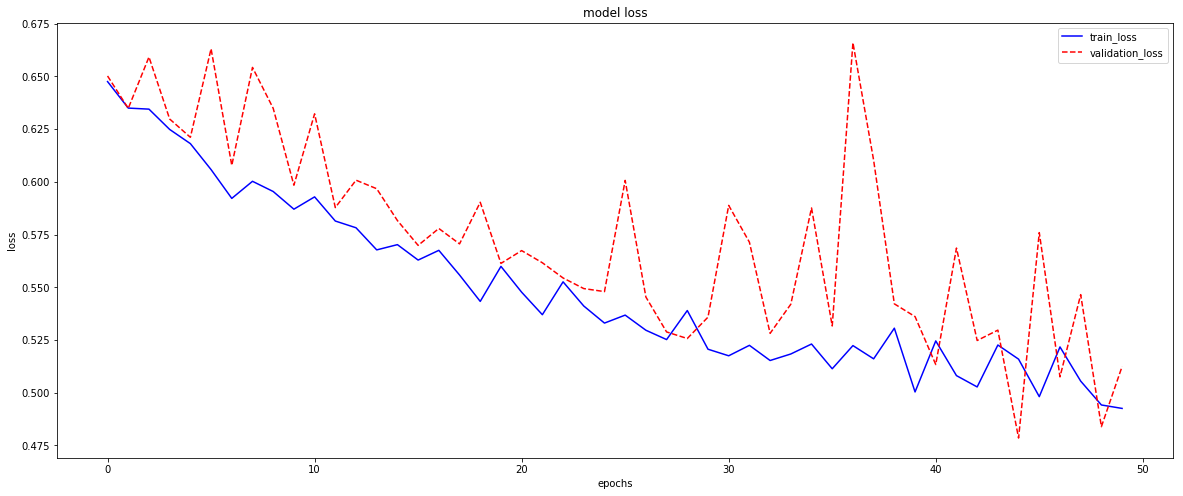

In [27]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["loss"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

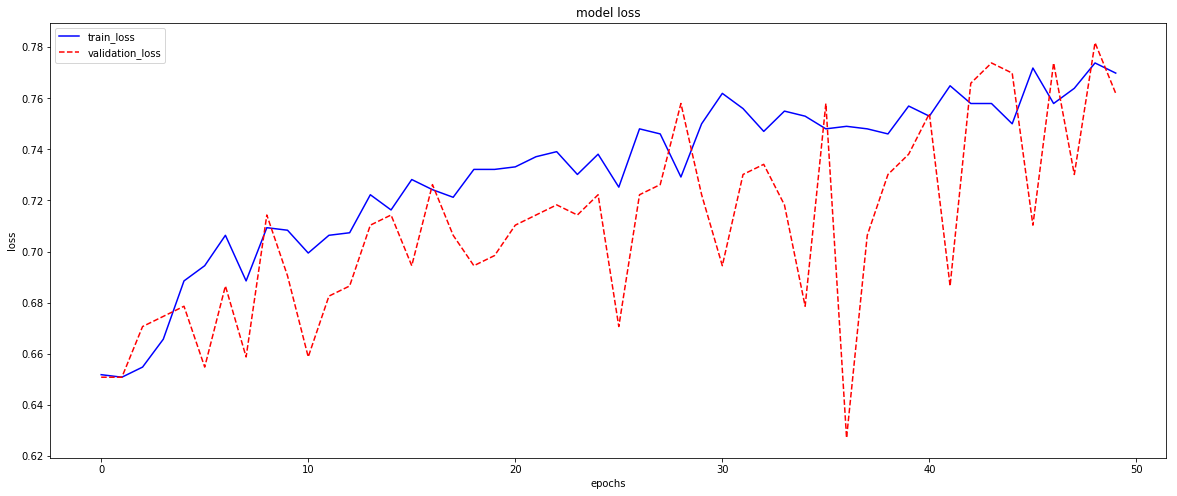

In [28]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(blackbox.history.history["acc"], color = "blue", label = "train_loss")
plt.plot(blackbox.history.history["val_acc"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

### load best weights

In [22]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/phalanges_blackbox_simpleCNN_20191101_170209_best_weights_+0.83_.hdf5")

In [115]:
blackbox.evaluate(X_test, y_test)

858/858 [==============================] - 2s 2ms/step


[0.4892052703109377, 0.7680652683431451]

In [23]:
simplecnn = blackbox

## KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

### grid search

In [30]:
#metriche usate nella grid search
scoring = {'MSE':make_scorer(mean_squared_error, greater_is_better=False), 'Accuracy': make_scorer(accuracy_score)}

#iperparametri
n_neighbors = list(range(1, 100))
metric = ["euclidean", "manhattan"]
#weights = ['uniform', 'distance']
weights = ['distance']
param_grid = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

#Definition of algorithm and GridSearch
knn = KNeighborsClassifier(algorithm='auto')
cv = StratifiedKFold(random_state=random_state, n_splits=3)
grid = GridSearchCV(knn, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs=-1, 
                    return_train_score=True, refit='MSE', verbose=1)

In [31]:
%%time
grid.fit(X_train.reshape(X_train.shape[:2]), y_train)
results = grid.cv_results_

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.1s


CPU times: user 2.37 s, sys: 847 ms, total: 3.21 s
Wall time: 40.8 s


[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:   40.7s finished


In [32]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}

In [33]:
df_results = pd.DataFrame(results)

In [34]:
df_results.at[grid.best_index_, 'mean_test_Accuracy']

0.7996031746031746

In [35]:
# creo un datframe per ogni misura di distanza
df_results = df_results.sort_index()
df_per_metric = []
for distance in metric:
    df_per_metric.append(df_results[df_results["param_metric"] == distance])  

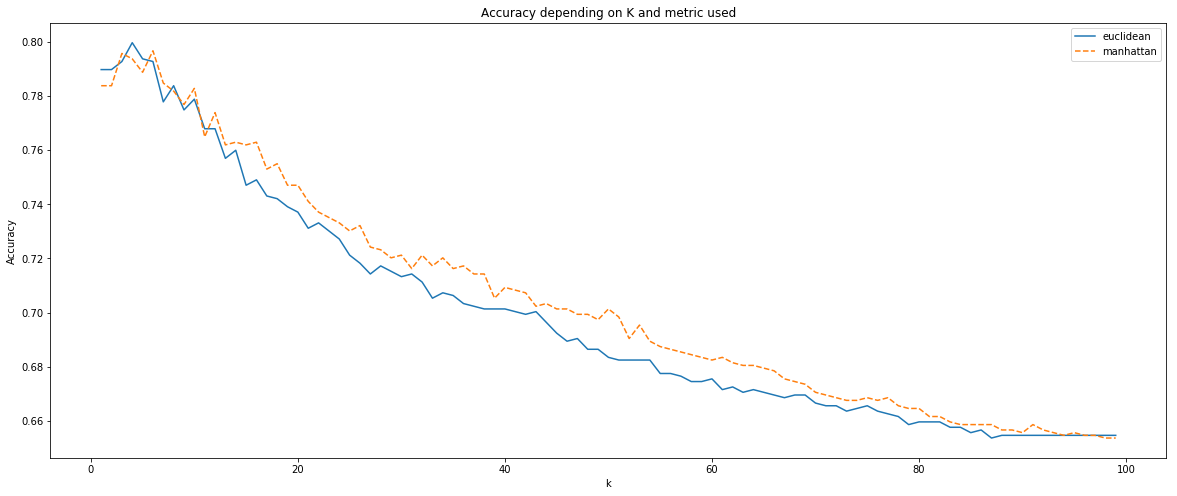

In [36]:
plt.figure(figsize=(20,8))
plt.title('Accuracy depending on K and metric used')
plt.ylabel('Accuracy')
plt.xlabel('k')
linestyles = ['-', '--', '-.', ':']

for i in range(len(df_per_metric)):
    plt.plot(df_per_metric[i]["param_n_neighbors"], df_per_metric[i]["mean_test_Accuracy"], linestyle = linestyles[i], label = metric[i])

plt.legend()
plt.show()

In [37]:
#salva la tabella dei risultati con data + parametri migliori
#chiede da solo in input da tastiera il nome del dataset da usare all'inizio del nome del file

date = time.strftime("%Y%m%d_%H%M%S")
parameter_string = ""
for key in grid.best_params_:
    parameter_name = key
    best = str(grid.best_params_[key])
    parameter_string += parameter_name + "[" + best + "]" + "__"
#to_csv("avg_df_{}.csv".format(date), sep = ";", index = False)
filename = date + "__" + parameter_string
df_results.to_csv(parentdir + "/gridsearches/{}__{}.csv".format(dataset_name, filename), sep = ";", index = False)

### save knn with best params

In [38]:
knn = KNeighborsClassifier(**grid.best_params_)

In [39]:
knn.fit(X_train.reshape(X_train.shape[:2]), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [40]:
path = parentdir + "/blackbox_checkpoints/" + dataset_name + "_blackbox_knn_" + (
    time.strftime("%Y%m%d_%H%M%S") + ".joblib")
dump(knn, path) 

['./blackbox_checkpoints/phalanges_blackbox_knn_20191101_171534.joblib']

### load best knn

In [25]:
knn = load(parentdir + "/blackbox_checkpoints/phalanges_blackbox_knn_20191101_171534.joblib")

In [43]:
knn.score(X_test.reshape(X_test.shape[:2]), y_test)

0.7832167832167832

In [44]:
mean_squared_error(y_test, knn.predict(X_test.reshape(X_test.shape[:2])))

0.21678321678321677

# AUTOENCODER TRAINING

In [69]:
# TENSORBOARD
# tensorboard --logdir=/tmp/autoencoder
# http://0.0.0.0:6006
# lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

In [517]:
import autoencoders
from autoencoders import *
import importlib
importlib.reload(autoencoders)

<module 'autoencoders' from '/Users/francesco/github/TESI/tests/autoencoders.py'>

## Standard

In [21]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 40,
          "encoder_latent_layer_type": "simple",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,2]}
         }

aut = Autoencoder(**params)
encoder, decoder, autoencoder = aut.build()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 1)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 80, 2)             44        
_________________________________________________________________
batch_normalization_13 (Batc (None, 80, 2)             8         
_________________________________________________________________
activation_10 (Activation)   (None, 80, 2)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 80, 2)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 80, 4)             148       
_________________________________________________________________
batch_normalization_14 (Batc (None, 80, 4)             16  

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 80, 1)             0         
_________________________________________________________________
Encoder (Model)              (None, 40)                166417    
_________________________________________________________________
Decoder (Model)              (None, 80, 1)             294857    
Total params: 461,274
Trainable params: 459,234
Non-trainable params: 2,040
_________________________________________________________________
None


In [49]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.4f}_.hdf5")

to_dict = open(parentdir + "/autoencoder_checkpoints/" + dataset_name + "_autoencoder_" + (
    time.strftime("%Y%m%d_%H%M%S") + "_best_weights_.txt"),"w")
to_dict.write( str(params) )
to_dict.close()

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor='val_loss', 
                                                   save_weights_only = True, verbose = 1,
                                                   save_best_only=True)
callbacks = [reduce_lr,model_checkpoint]


In [50]:
history = autoencoder.fit(X_exp_train, X_exp_train, epochs=200, validation_data=(X_exp_val, X_exp_val), verbose = 1, 
                callbacks = callbacks)

Train on 345 samples, validate on 87 samples
Epoch 1/200
345/345 [==============================] - 11s 32ms/step - loss: 0.3466 - val_loss: 0.1790

Epoch 00001: val_loss improved from inf to 0.17898, saving model to ./autoencoder_checkpoints/phalanges_autoencoder_20191101_171746_best_weights_+0.1790_.hdf5
Epoch 2/200
345/345 [==============================] - 3s 9ms/step - loss: 0.0607 - val_loss: 0.1215

Epoch 00002: val_loss improved from 0.17898 to 0.12147, saving model to ./autoencoder_checkpoints/phalanges_autoencoder_20191101_171746_best_weights_+0.1215_.hdf5
Epoch 3/200
345/345 [==============================] - 4s 10ms/step - loss: 0.0470 - val_loss: 0.0959

Epoch 00003: val_loss improved from 0.12147 to 0.09588, saving model to ./autoencoder_checkpoints/phalanges_autoencoder_20191101_171746_best_weights_+0.0959_.hdf5
Epoch 4/200
345/345 [==============================] - 4s 10ms/step - loss: 0.0399 - val_loss: 0.0799

Epoch 00004: val_loss improved from 0.09588 to 0.07991, sa

345/345 [==============================] - 4s 11ms/step - loss: 0.0097 - val_loss: 0.0176

Epoch 00043: val_loss did not improve from 0.01544
Epoch 44/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0091 - val_loss: 0.0189

Epoch 00044: val_loss did not improve from 0.01544
Epoch 45/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0087 - val_loss: 0.0154

Epoch 00045: val_loss improved from 0.01544 to 0.01540, saving model to ./autoencoder_checkpoints/phalanges_autoencoder_20191101_171746_best_weights_+0.0154_.hdf5
Epoch 46/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0085 - val_loss: 0.0162

Epoch 00046: val_loss did not improve from 0.01540
Epoch 47/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0086 - val_loss: 0.0158

Epoch 00047: val_loss did not improve from 0.01540
Epoch 48/200
345/345 [==============================] - 3s 9ms/step - loss: 0.0086 - val_loss: 0.0178

Epoch 00048: val_loss d

345/345 [==============================] - 3s 9ms/step - loss: 0.0051 - val_loss: 0.0134

Epoch 00139: val_loss did not improve from 0.01231
Epoch 140/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0051 - val_loss: 0.0143

Epoch 00140: val_loss did not improve from 0.01231
Epoch 141/200
345/345 [==============================] - 3s 10ms/step - loss: 0.0055 - val_loss: 0.0137

Epoch 00141: val_loss did not improve from 0.01231
Epoch 142/200
345/345 [==============================] - 3s 9ms/step - loss: 0.0053 - val_loss: 0.0136

Epoch 00142: val_loss did not improve from 0.01231
Epoch 143/200
345/345 [==============================] - 3s 9ms/step - loss: 0.0054 - val_loss: 0.0136

Epoch 00143: val_loss did not improve from 0.01231
Epoch 144/200
345/345 [==============================] - 3s 9ms/step - loss: 0.0056 - val_loss: 0.0160

Epoch 00144: val_loss did not improve from 0.01231
Epoch 145/200
345/345 [==============================] - 3s 9ms/step - loss: 0.005

345/345 [==============================] - 4s 12ms/step - loss: 0.0045 - val_loss: 0.0143

Epoch 00191: val_loss did not improve from 0.01152
Epoch 192/200
345/345 [==============================] - 4s 12ms/step - loss: 0.0042 - val_loss: 0.0125

Epoch 00192: val_loss did not improve from 0.01152
Epoch 193/200
345/345 [==============================] - 5s 15ms/step - loss: 0.0039 - val_loss: 0.0124

Epoch 00193: val_loss did not improve from 0.01152
Epoch 194/200
345/345 [==============================] - 5s 14ms/step - loss: 0.0037 - val_loss: 0.0123

Epoch 00194: val_loss did not improve from 0.01152
Epoch 195/200
345/345 [==============================] - 4s 12ms/step - loss: 0.0038 - val_loss: 0.0124

Epoch 00195: val_loss did not improve from 0.01152
Epoch 196/200
345/345 [==============================] - 5s 14ms/step - loss: 0.0037 - val_loss: 0.0119

Epoch 00196: val_loss did not improve from 0.01152
Epoch 197/200
345/345 [==============================] - 5s 14ms/step - loss: 

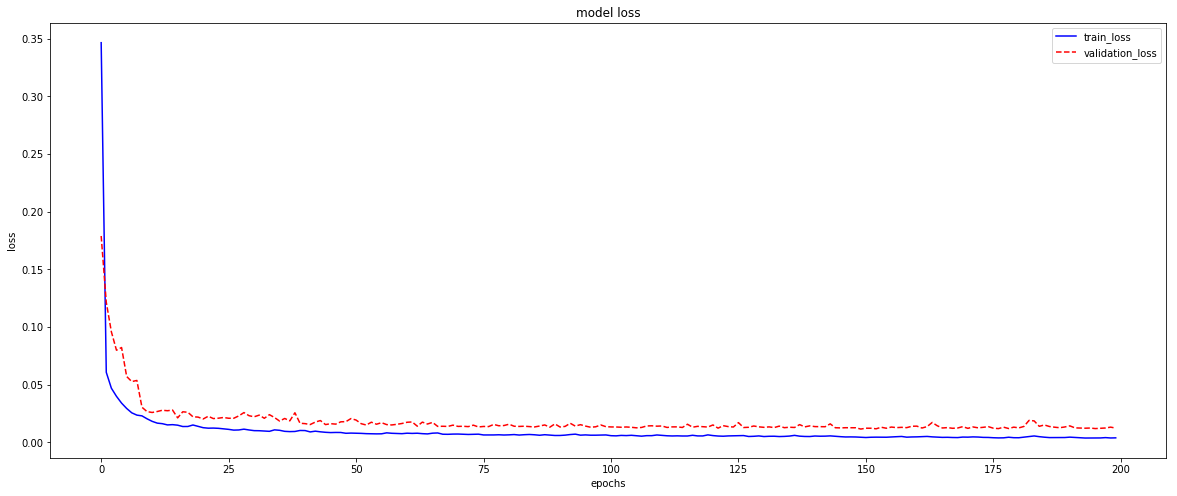

In [51]:
plt.figure(figsize=(20,8))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history["loss"], color = "blue", label = "train_loss")
plt.plot(history.history["val_loss"], color = "red", linestyle = "dashed", label = "validation_loss")
plt.legend()

plt.show()

In [22]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/phalanges_autoencoder_20191103_211535_best_weights_+0.0010_.hdf5")

In [23]:
autoencoder.evaluate(X_exp_val, X_exp_val)

87/87 [==============================] - 1s 9ms/step


0.0010495693289043232

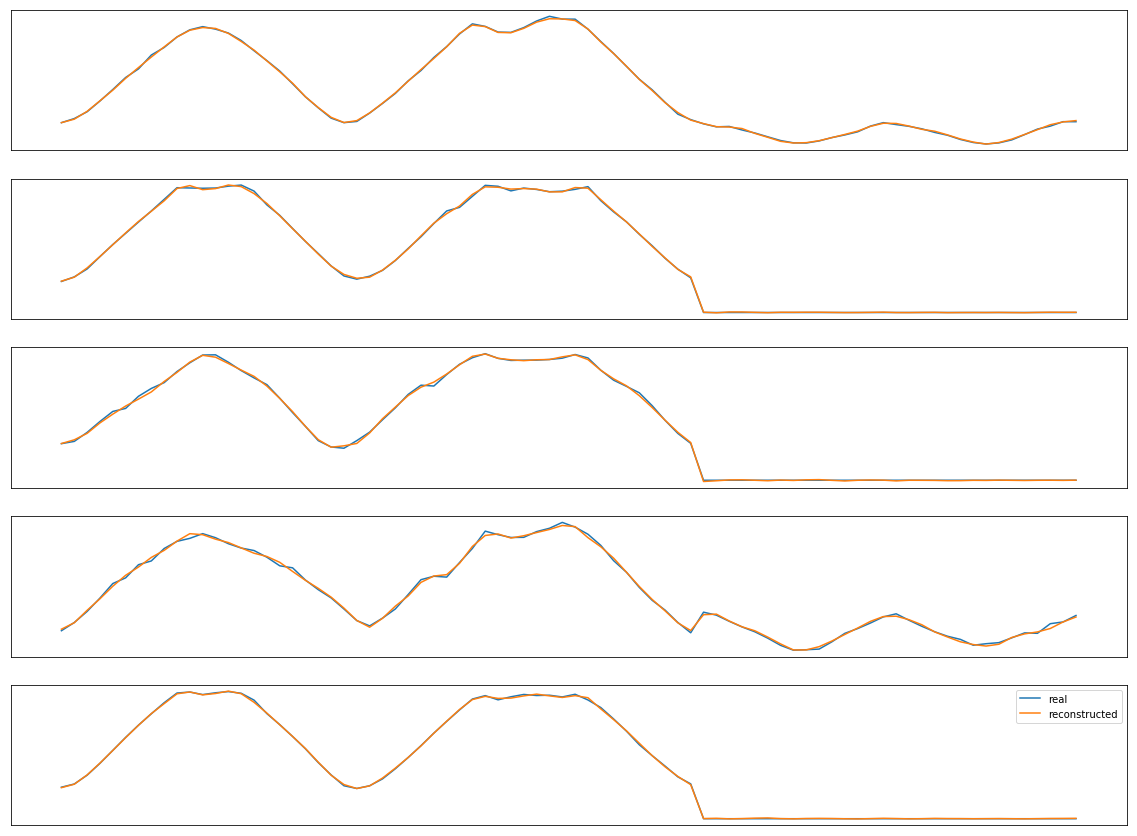

In [198]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()

## STANDARD (LSTM)

In [19]:
from toy_autoencoders import build_lstm_autoencoder
from myutils import reconstruction_blackbox_consistency

In [20]:
autoencoder = build_lstm_autoencoder(n_timesteps, 40)

In [ ]:
file_path = parentdir + "/autoencoder_checkpoints/" + dataset_name + "_lstm_autoencoder_" + (time.strftime("%Y%m%d_%H%M%S") + "_best_weights_+{val_loss:.6f}_.hdf5")

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                  monitor='val_loss', 
                                                  save_weights_only = True, verbose = 1,
                                                  save_best_only=True)
callbacks = [model_checkpoint]

In [ ]:
history = model.fit(X_exp_train, X_exp_train, epochs=200, validation_data=(X_exp_val, X_exp_val), verbose = 1, callbacks = callbacks)

In [21]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/phalanges_lstm_autoencoder_20191130_214525_best_weights_+0.014177_.hdf5")

In [22]:
reconstruction_blackbox_consistency(autoencoder, blackbox, X_exp_test)

0.6759259259259259

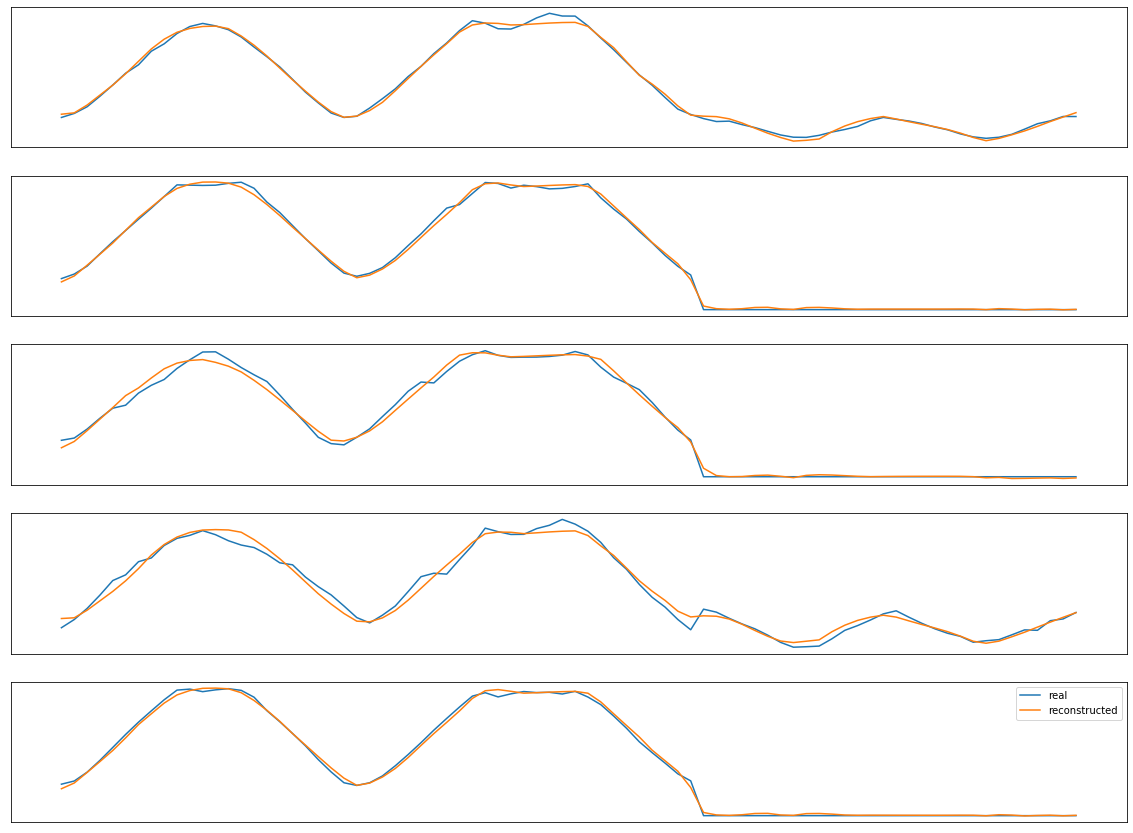

In [24]:
decoded_tss = autoencoder.predict(X_exp_val)
n = 10
g = 1
plt.figure(figsize=(20, 15))
for i in range(n, n+5):
    # display original
    ax = plt.subplot(5, 1, g)
    g  += 1
    plt.plot(X_exp_val[i], label = "real")
    plt.plot(decoded_tss[i], label = "reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.legend()
plt.show()